In [ ]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt


# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['disneyland','tokyo','disney', 'im', 'tdrnow','paris','california','amp','disneysea','got',
                 'ºc', 'ºf', 'ºoº','𝗧𝗵𝗲','くまのプーさん', 'ディズニー', 'ディズニーシー','ディズニーハロウィーン',
                 'ディズニーランド', 'ディズニー好きと繋がりたい', 'フェスティバルオブミスティーク', 'マルマン',
                 'ㅋㅋㅋ', '場所', '更新', '月released', '東京ディズニーシー', '東京ディズニーランド', '東京ディズニーリゾート',
                 '香港迪士尼樂園', 'ºº', 'hong', 'kong',"disneylandresort", "disneyland", "disneyresort",
                  "californiaadventure",'downtowndisney','disneyanaheim','disneylandanaheim',
                  'disneycalifornia','californiadisney','disneysea', 'disneytokyo', 'disneytokyoresort', 
                  'tokyodisney','tokyodisneyresort', 'tokyodisneyland','東京ディズニーランド', 'ディズニーランド',
                  '東京ディズニーシー', 'ズニーシー', 'tdr_now', 'tdr_md','tdr','dca','dl', 'wdw','disneylandparis',
                  'theme_park', 'min', 'day', 'new', 'guy', 'year', 'way', 'part', 'thing', 'man','ティスニー',
                  'side', 'sia', 'ティスニーラント', 'ティスニーハロウィーン', 'today', 'wanna', 'place',
                  'world', 'disneyworld', 'next', 'disneypark', '東京ティスニーシー', 'yen',
                  '東京ティスニーラント', 'land', 'park', 'ティスニーシー', 'tdl', 'tdrmd', 'lot',
                  "東京ティスニーリソート"])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [2]:
df = pd.read_json('DiSmldata.json')

In [3]:
df_ja_neg = df[(df['label'] == 0)]

In [4]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df_ja_neg.clean_text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['its', 'long', 'time', 'since', 'ive', 'lot', 'fun', 'atdisneyland', 'but', 'tired', 'feeling', 'old', 'ティスニーラント', 'カリフの海賊', 'ラフンツェルのハケット', 'ティスニーラント']]


In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=20) # higher threshold fewer phrases. Must show up more than 2 times the phrases 
trigram = gensim.models.Phrases(bigram[data_words], threshold=20)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [6]:
data_ready[0:10]

[['long_time',
  'fun',
  'atdisneyland',
  'tired',
  'feeling',
  'old',
  'カリフの海賊',
  'ラフンツェルのハケット'],
 ['mystiques_first',
  'midway',
  'wind',
  'trap',
  'canheadholde',
  'regret',
  'frustrating',
  'flow',
  'flow',
  'cute',
  'tear'],
 ['geek',
  'test',
  'find',
  'net',
  'try',
  'kill',
  'time',
  'result',
  'bgs',
  'mania',
  'person',
  'correct',
  'answer',
  'question',
  'question',
  'people',
  'good',
  'result'],
 ['mamerag',
  'right',
  'ariel',
  'layer',
  'sit',
  'prince',
  'eric',
  'statue',
  'taking_picture'],
 ['take',
  'photo',
  'iphone',
  'pro',
  'quality',
  'equipment',
  'always',
  'pocket',
  'iphone',
  'scary'],
 ['already',
  'smartphone',
  'job',
  'first',
  'annual_income',
  'teach_earn',
  'first',
  'add_line'],
 ['olc',
  'announce',
  'revise',
  'fee',
  'april',
  'cry',
  'adult',
  'mediumsein',
  'child',
  'annual_passport',
  'https'],
 ['bad', 'yesterday'],
 ['change', 'nightmare', 'christmas', 'haunted_mansion', '

In [7]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [8]:
#3 Topics
lda_model3 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=20,
                                           per_word_topics=True)

In [9]:
pprint(lda_model3.print_topics())

[(0,
  '0.019*"indie_jone" + 0.016*"think" + 0.014*"fast_pass" + 0.014*"want" + '
  '0.011*"say" + 0.011*"recover" + 0.010*"ghost" + 0.010*"make" + 0.010*"try" '
  '+ 0.009*"take"'),
 (1,
  '0.020*"people" + 0.018*"usual" + 0.016*"expect" + 0.016*"sea" + '
  '0.013*"halloween" + 0.012*"good" + 0.010*"person" + 0.009*"come" + '
  '0.009*"see" + 0.009*"work"'),
 (2,
  '0.025*"go" + 0.020*"raging_spirits" + 0.015*"also" + 0.013*"get" + '
  '0.012*"time" + 0.011*"put" + 0.010*"buy" + 0.010*"become" + 0.009*"ill" + '
  '0.008*"soon"')]


In [10]:
#4 Topics
lda_model4 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=20,
                                           per_word_topics=True)

In [11]:
pprint(lda_model4.print_topics())

[(0,
  '0.026*"fast_pass" + 0.025*"expect" + 0.023*"think" + 0.020*"want" + '
  '0.015*"ghost" + 0.014*"make" + 0.013*"work" + 0.012*"first" + 0.012*"show" '
  '+ 0.011*"wait"'),
 (1,
  '0.027*"usual" + 0.022*"sea" + 0.018*"seem" + 0.016*"time" + 0.014*"person" '
  '+ 0.011*"last" + 0.009*"still" + 0.009*"use" + 0.009*"second" + '
  '0.008*"know"'),
 (2,
  '0.025*"indie_jone" + 0.022*"recover" + 0.019*"also" + 0.017*"get" + '
  '0.016*"go" + 0.015*"say" + 0.014*"put" + 0.013*"come" + 0.012*"become" + '
  '0.011*"ill"'),
 (3,
  '0.026*"people" + 0.026*"raging_spirits" + 0.017*"halloween" + 0.015*"good" '
  '+ 0.015*"go" + 0.013*"try" + 0.013*"buy" + 0.012*"see" + 0.011*"take" + '
  '0.009*"eye"')]


In [12]:
#5 Topics
lda_model5 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=20,
                                           per_word_topics=True)

In [13]:
pprint(lda_model5.print_topics())

[(0,
  '0.032*"expect" + 0.025*"want" + 0.024*"halloween" + 0.018*"make" + '
  '0.015*"first" + 0.014*"dark" + 0.013*"eye" + 0.012*"mean" + 0.012*"lose" + '
  '0.012*"cry"'),
 (1,
  '0.035*"people" + 0.028*"think" + 0.019*"say" + 0.018*"ghost" + 0.017*"try" '
  '+ 0.014*"wait" + 0.011*"use" + 0.010*"know" + 0.009*"bad" + 0.008*"cast"'),
 (2,
  '0.045*"go" + 0.038*"raging_spirits" + 0.033*"fast_pass" + 0.019*"buy" + '
  '0.017*"work" + 0.013*"early" + 0.009*"small" + 0.009*"devil" + '
  '0.009*"operation" + 0.009*"long_pizza"'),
 (3,
  '0.036*"usual" + 0.022*"good" + 0.018*"see" + 0.018*"recover" + 0.016*"take" '
  '+ 0.013*"still" + 0.012*"dangerous" + 0.011*"villain" + 0.009*"photo" + '
  '0.009*"cut"'),
 (4,
  '0.027*"indie_jone" + 0.022*"sea" + 0.020*"also" + 0.018*"seem" + '
  '0.017*"get" + 0.016*"time" + 0.015*"put" + 0.014*"person" + 0.014*"recover" '
  '+ 0.013*"come"')]


In [14]:
#6 Topics
lda_model6 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=20,
                                           per_word_topics=True)

In [15]:
pprint(lda_model6.print_topics())

[(0,
  '0.035*"fast_pass" + 0.034*"expect" + 0.030*"think" + 0.025*"want" + '
  '0.021*"say" + 0.016*"take" + 0.015*"first" + 0.015*"last" + 0.015*"wait" + '
  '0.014*"soon"'),
 (1,
  '0.046*"raging_spirits" + 0.044*"indie_jone" + 0.024*"ghost" + 0.023*"try" + '
  '0.021*"work" + 0.013*"know" + 0.012*"seriously" + 0.011*"bad" + '
  '0.011*"tdrfood" + 0.011*"operation"'),
 (2,
  '0.020*"dark" + 0.018*"early" + 0.017*"still" + 0.017*"lose" + '
  '0.015*"villain" + 0.013*"small" + 0.012*"gachapin" + 0.012*"mare" + '
  '0.012*"trouble" + 0.012*"change"'),
 (3,
  '0.043*"go" + 0.028*"sea" + 0.026*"also" + 0.021*"time" + 0.020*"put" + '
  '0.018*"make" + 0.018*"buy" + 0.017*"come" + 0.017*"become" + 0.015*"ill"'),
 (4,
  '0.040*"people" + 0.030*"recover" + 0.026*"seem" + 0.025*"get" + '
  '0.021*"person" + 0.013*"sorry" + 0.013*"second" + 0.012*"stop" + '
  '0.012*"wonder" + 0.012*"angry"'),
 (5,
  '0.046*"usual" + 0.032*"halloween" + 0.029*"good" + 0.023*"see" + '
  '0.015*"dangerous" + 0.0

In [16]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model3, corpus, dictionary=lda_model3.id2word)
vis

/Users/justin/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.155830 -0.123707       1        1  34.932590
1     -0.197501 -0.059047       2        1  34.597847
2      0.041671  0.182754       3        1  30.469570, topic_info=     Category        Freq            Term       Total  loglift  logprob
107   Default  147.000000              go  147.000000  30.0000  30.0000
27    Default  131.000000          people  131.000000  29.0000  29.0000
4515  Default  132.000000      indie_jone  132.000000  28.0000  28.0000
4845  Default  124.000000  raging_spirits  124.000000  27.0000  27.0000
1273  Default  126.000000           usual  126.000000  26.0000  26.0000
...       ...         ...             ...         ...      ...      ...
4767   Topic3   26.778742            hkdl   37.332333   0.8562  -5.3880
3746   Topic3   27.023966           bread   38.203835   0.8422  -5.3789
4075   Topic3   24.329378            mare   29.907700   0.9820  -5.4839
100    Topic3   33.499554            seem   83.225372   0.2784  -5.1641
4162   Topic3   38.128448         recover  126.764168  -0.0129  -5.0347

[149 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
242       1  0.983260      able
2092      1  0.043122  addition
2092      2  0.043122  addition
2092      3  0.948687  addition
53        2  0.982846   already
...     ...       ...       ...
526       1  0.981876      wait
317       1  0.996887      want
155       3  0.974397    wonder
171       1  0.016922      work
171       2  0.964579      work

[167 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [17]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model6, corpus, dictionary=lda_model6.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.264247  0.095141       1        1  19.740810
4     -0.088261 -0.017138       2        1  19.732738
0     -0.155674  0.212185       3        1  18.051838
5     -0.005936 -0.133765       4        1  15.670792
2      0.020299  0.002921       5        1  14.153997
1     -0.034674 -0.159345       6        1  12.649828, topic_info=     Category        Freq            Term       Total  loglift  logprob
107   Default  164.000000              go  164.000000  30.0000  30.0000
1273  Default  140.000000           usual  140.000000  29.0000  29.0000
27    Default  153.000000          people  153.000000  28.0000  28.0000
4845  Default  113.000000  raging_spirits  113.000000  27.0000  27.0000
4515  Default  110.000000      indie_jone  110.000000  26.0000  26.0000
...       ...         ...             ...         ...      ...      ...
165    Topic6   11.546210    announcement   12.288113   2.0053  -5.3502
2785   Topic6   11.626863    mickey_mouse   12.435854   2.0003  -5.3432
1779   Topic6   26.088228       operation   28.198294   1.9897  -4.5351
801    Topic6   17.059004           daisy   18.838058   1.9683  -4.9599
3944   Topic6   12.232070            ball   13.926863   1.9378  -5.2925

[235 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
242       4  0.972504      able
2092      3  0.976056  addition
2359      2  0.950861    almost
53        3  0.946507   already
87        1  0.996995      also
...     ...       ...       ...
155       2  0.974984    wonder
171       6  0.982021      work
683       1  0.958166   worried
600       4  0.978268       www
532       5  0.944027       スフフ

[235 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 1, 6, 3, 2])

In [18]:
#10 Topics
lda_model10 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=20,
                                           per_word_topics=True)

In [19]:
pprint(lda_model10.print_topics())

[(0,
  '0.034*"eye" + 0.031*"mean" + 0.031*"sorry" + 0.028*"angry" + 0.028*"break" '
  '+ 0.028*"little" + 0.025*"seriously" + 0.021*"look" + 0.019*"minnie" + '
  '0.018*"resort"'),
 (1,
  '0.067*"people" + 0.042*"seem" + 0.042*"get" + 0.034*"person" + 0.032*"come" '
  '+ 0.030*"work" + 0.025*"dark" + 0.020*"stop" + 0.020*"wonder" + '
  '0.018*"know"'),
 (2,
  '0.090*"go" + 0.037*"buy" + 0.035*"see" + 0.026*"early" + 0.021*"villain" + '
  '0.019*"able" + 0.019*"stock" + 0.017*"trouble" + 0.016*"purchase" + '
  '0.016*"dress"'),
 (3,
  '0.083*"think" + 0.057*"say" + 0.039*"soon" + 0.033*"lose" + 0.032*"cry" + '
  '0.032*"child" + 0.027*"store" + 0.024*"gachapin" + 0.024*"cast" + '
  '0.023*"site"'),
 (4,
  '0.068*"indie_jone" + 0.066*"fast_pass" + 0.039*"put" + 0.036*"make" + '
  '0.030*"ill" + 0.030*"take" + 0.028*"wait" + 0.018*"photo" + 0.016*"cut" + '
  '0.015*"stand"'),
 (5,
  '0.039*"use" + 0.038*"dangerous" + 0.029*"terrible" + 0.026*"fire" + '
  '0.025*"sit" + 0.021*"oneman" + 0

In [20]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model10, corpus, dictionary=lda_model10.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.322695 -0.036253       1        1  14.015065
6      0.108114  0.134340       2        1  12.113377
2     -0.040414  0.040778       3        1  11.825318
4      0.094533 -0.317828       4        1  10.796525
0      0.045858  0.051179       5        1  10.177090
9      0.033195  0.029089       6        1  10.093026
7      0.024670  0.044177       7        1   9.124925
3      0.019035  0.020837       8        1   8.806911
5      0.015767  0.010952       9        1   6.699850
8      0.021937  0.022731      10        1   6.347917, topic_info=     Category        Freq        Term       Total  loglift  logprob
107   Default  206.000000          go  206.000000  30.0000  30.0000
1273  Default  176.000000       usual  176.000000  29.0000  29.0000
4162  Default  176.000000     recover  176.000000  28.0000  28.0000
27    Default  180.000000      people  180.000000  27.0000  27.0000
296   Default  141.000000       think  141.000000  26.0000  26.0000
...       ...         ...         ...         ...      ...      ...
1646  Topic10    6.307341  production    7.244668   2.6185  -5.2653
4235  Topic10    6.017499  didnt_know    7.046368   2.5992  -5.3124
863   Topic10    4.281884         pas    5.219231   2.5591  -5.6526
1067  Topic10   12.308913   chocolate   15.013057   2.5584  -4.5967
4541  Topic10    8.411180       cover   11.165893   2.4737  -4.9775

[346 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
242       3  0.983185             able
2092      8  0.972239         addition
3347      9  0.944061  admission_limit
954       8  0.885043              age
510       8  0.924637            allow
...     ...       ...              ...
600       9  0.953186              www
71       10  0.958462        yesterday
2254      4  0.918741             york
532       5  0.979710              スフフ
1079      2  0.937479    ティスニー好きと繋かりたい

[334 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 3, 5, 1, 10, 8, 4, 6, 9])

In [ ]:
# Go with 6 topics for negative Japanese tweets

In [21]:
#Final Model 


#6 Topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [22]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.5903,"usual, work, eye, know, gachapin, change, end,...","[long_time, fun, atdisneyland, tired, feeling,..."
1,1,1.0,0.5414,"people, good, time, ghost, person, try, mean, ...","[mystiques_first, midway, wind, trap, canheadh..."
2,2,1.0,0.8054,"people, good, time, ghost, person, try, mean, ...","[geek, test, find, net, try, kill, time, resul..."
3,3,5.0,0.9065,"raging_spirits, halloween, buy, see, dangerous...","[mamerag, right, ariel, layer, sit, prince, er..."
4,4,0.0,0.6921,"expect, fast_pass, think, want, say, take, sho...","[take, photo, iphone, pro, quality, equipment,..."
5,5,0.0,0.7614,"expect, fast_pass, think, want, say, take, sho...","[already, smartphone, job, first, annual_incom..."
6,6,0.0,0.6159,"expect, fast_pass, think, want, say, take, sho...","[olc, announce, revise, fee, april, cry, adult..."
7,7,1.0,0.3889,"people, good, time, ghost, person, try, mean, ...","[bad, yesterday]"
8,8,2.0,0.6668,"usual, work, eye, know, gachapin, change, end,...","[change, nightmare, christmas, haunted_mansion..."
9,9,0.0,0.6225,"expect, fast_pass, think, want, say, take, sho...","[wish_could, erase, embarrassing, tweet, stupi..."


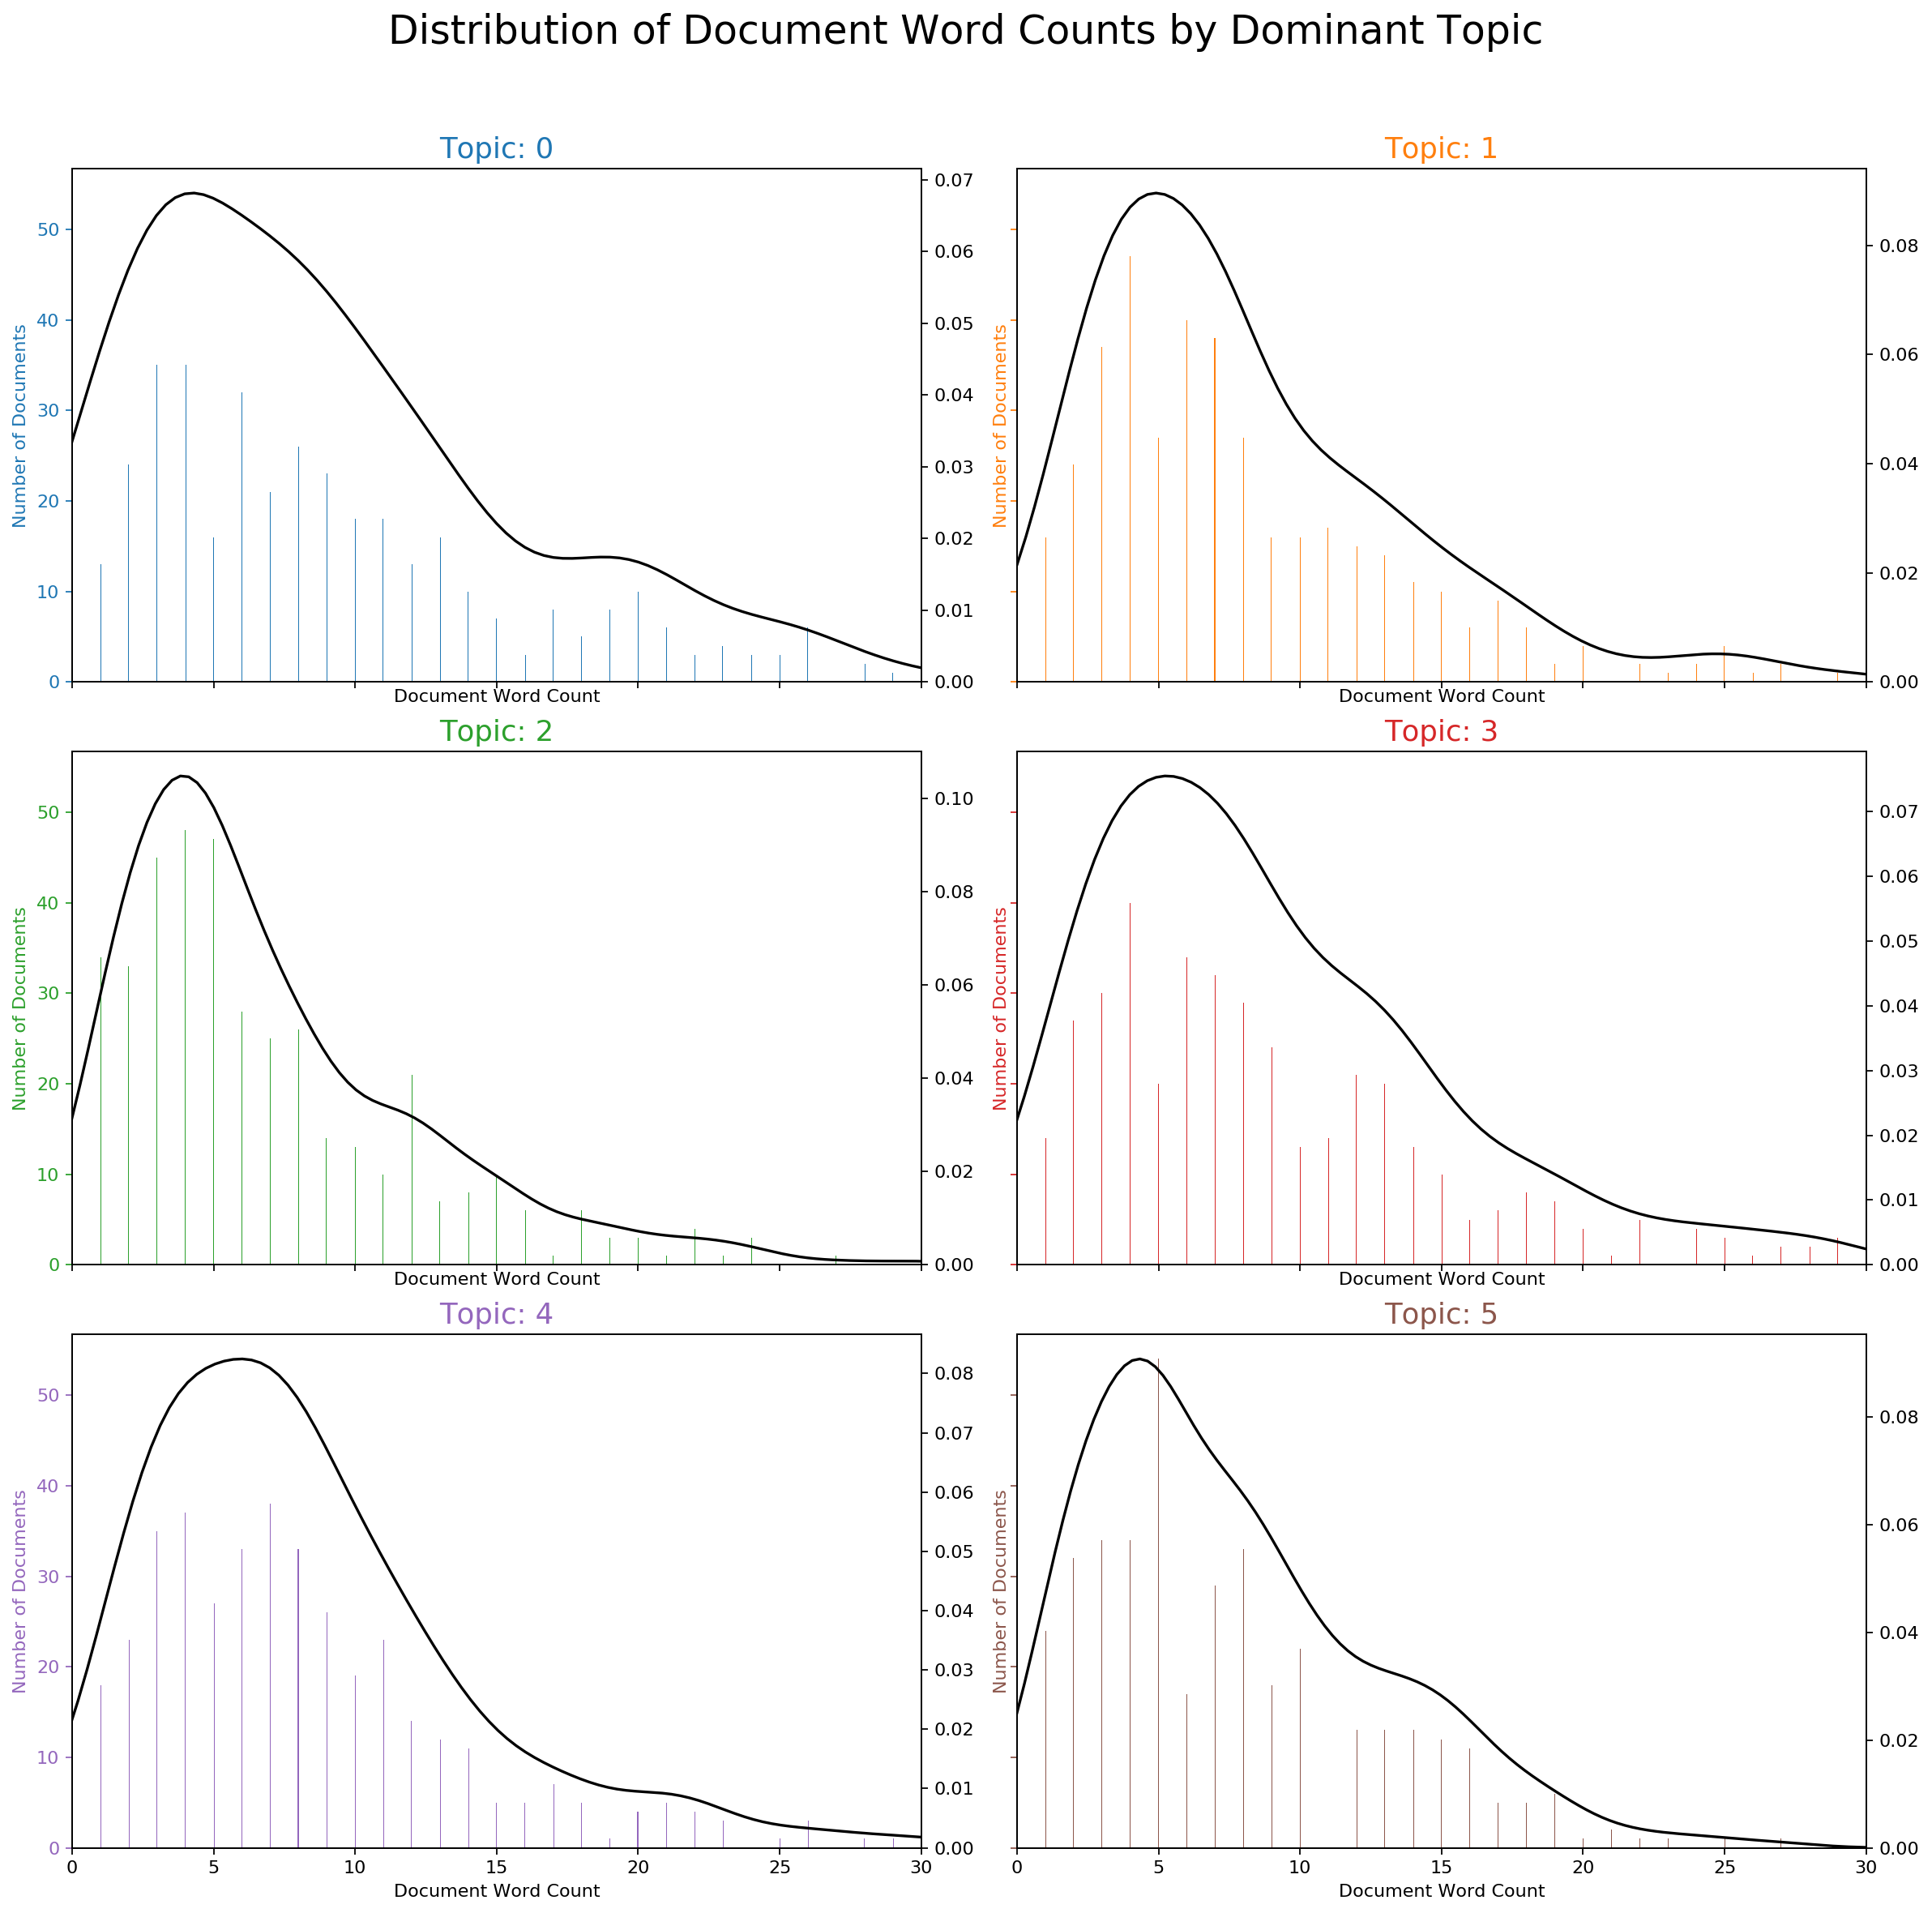

In [23]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,2,figsize=(15,15), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 30), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

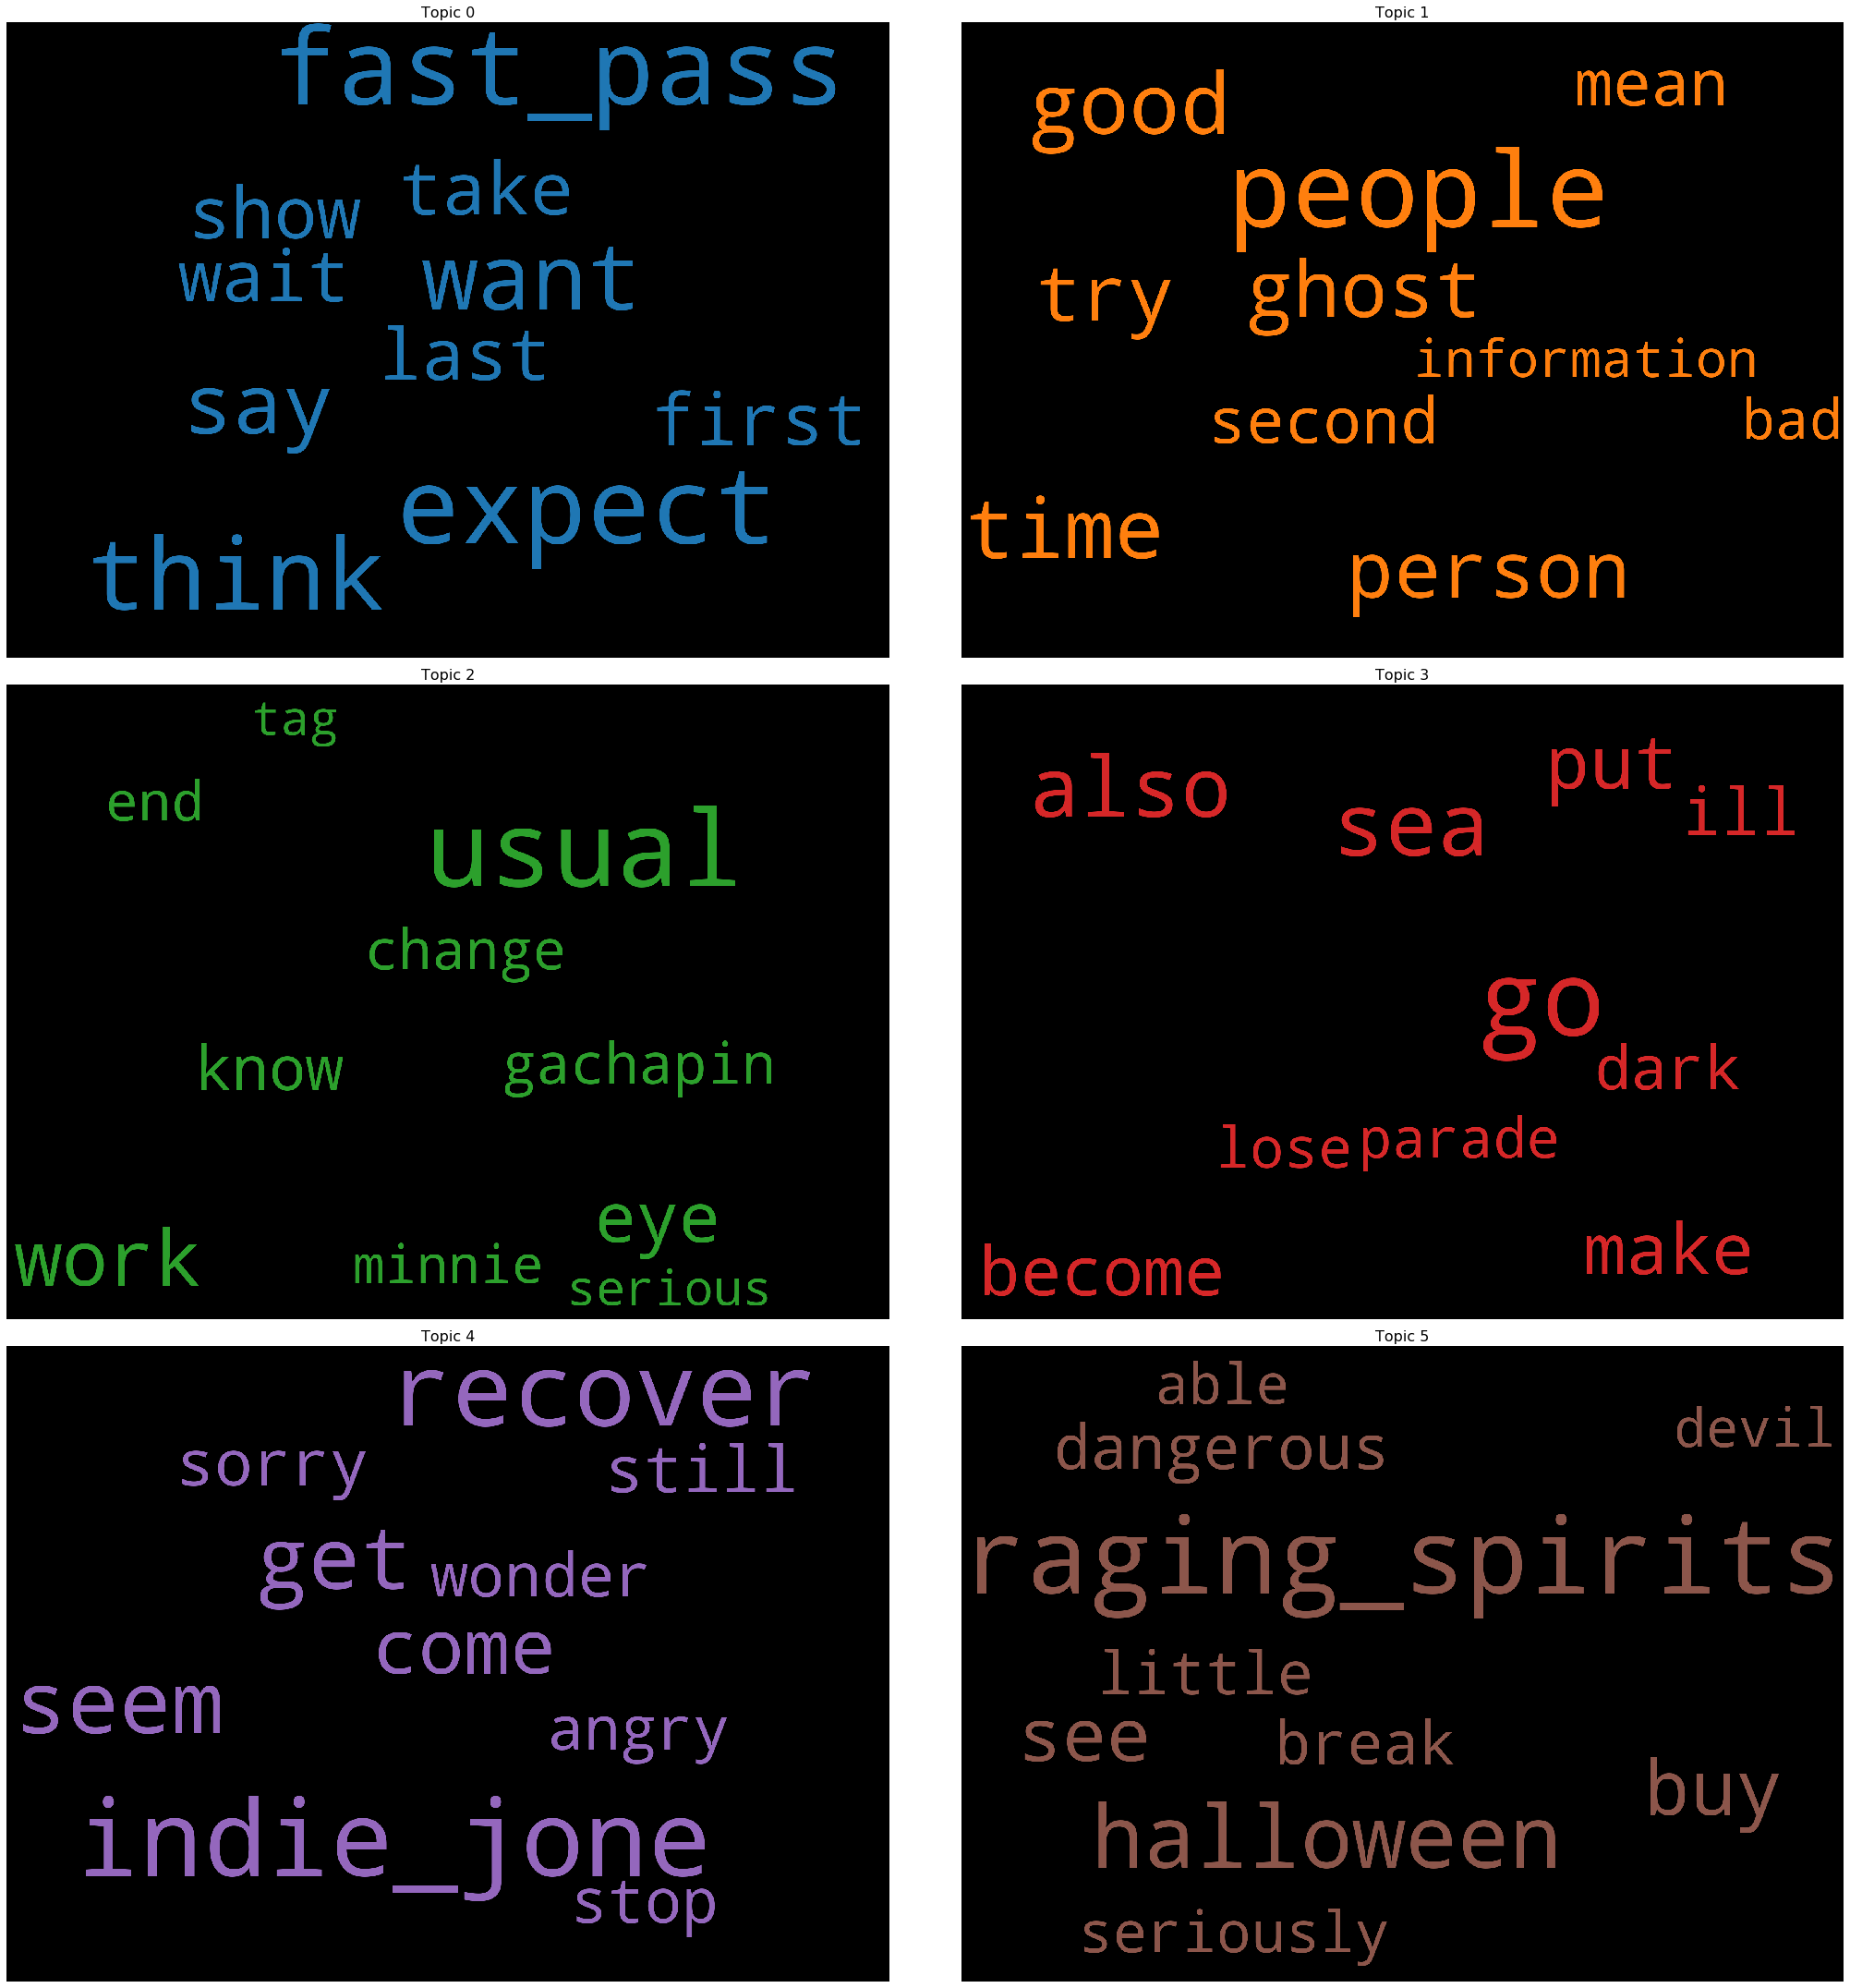

In [24]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='black',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(30,30), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

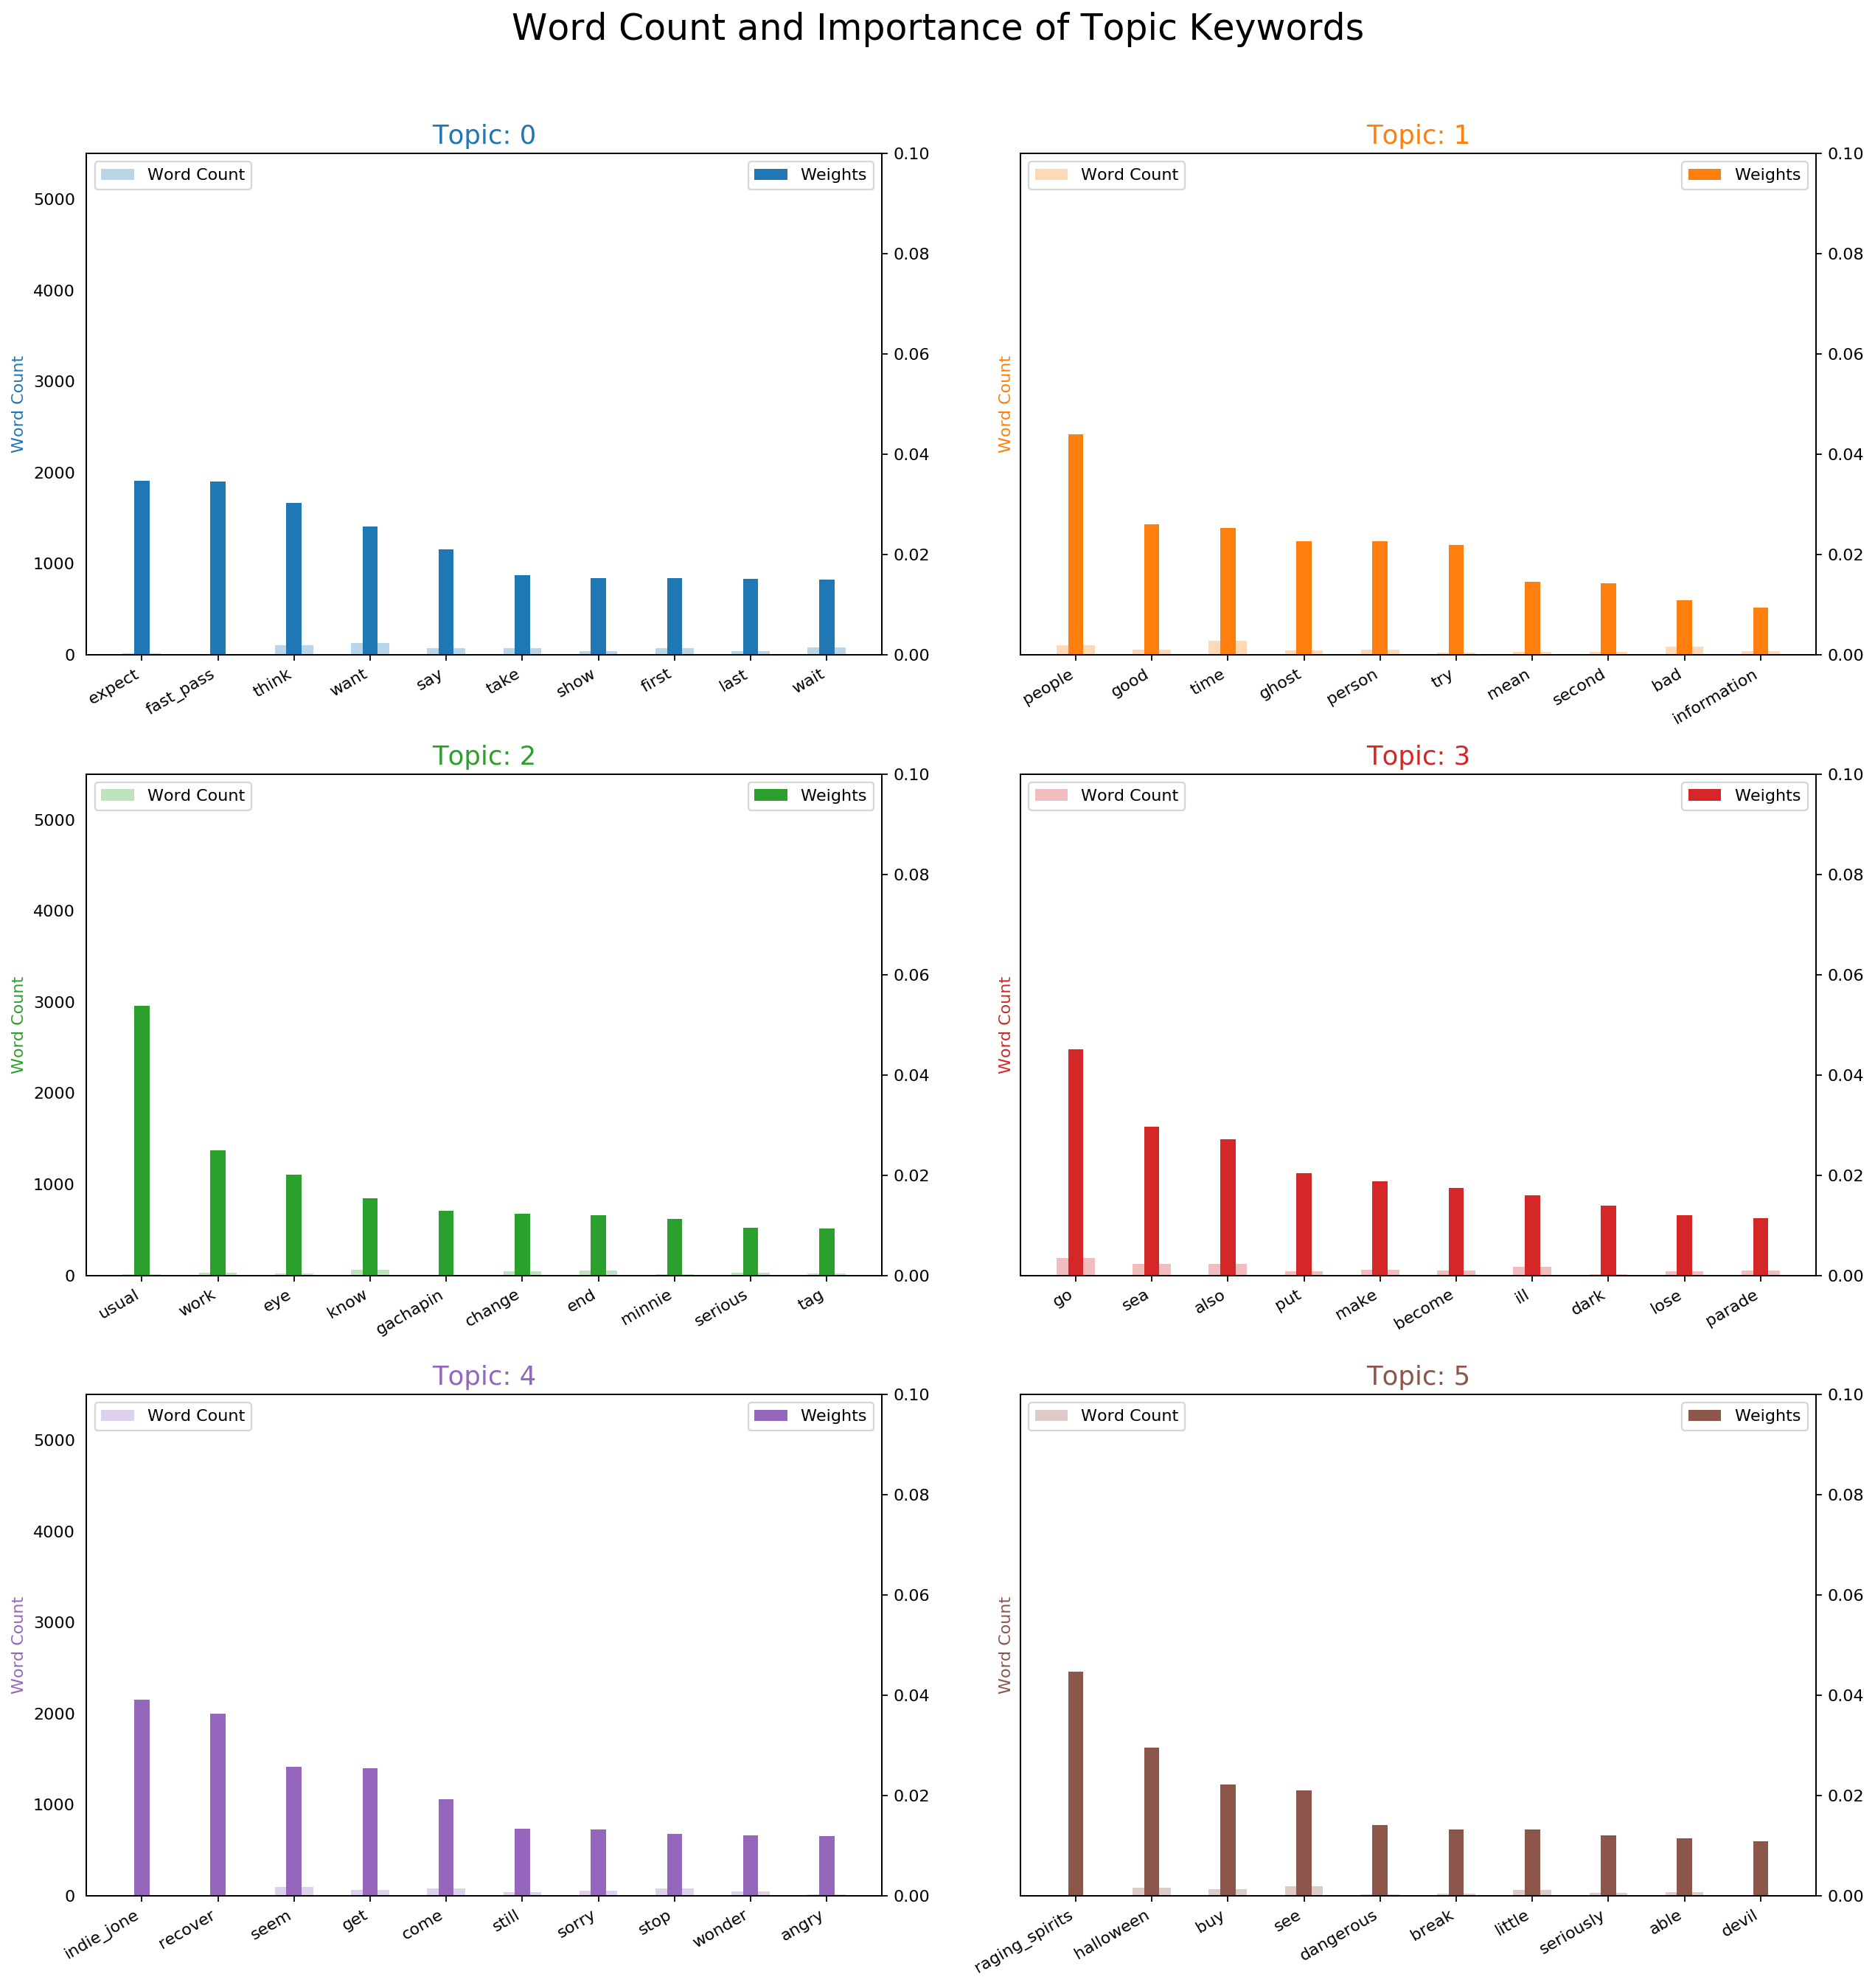

In [25]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(16,16), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.10); ax.set_ylim(0, 5500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [26]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

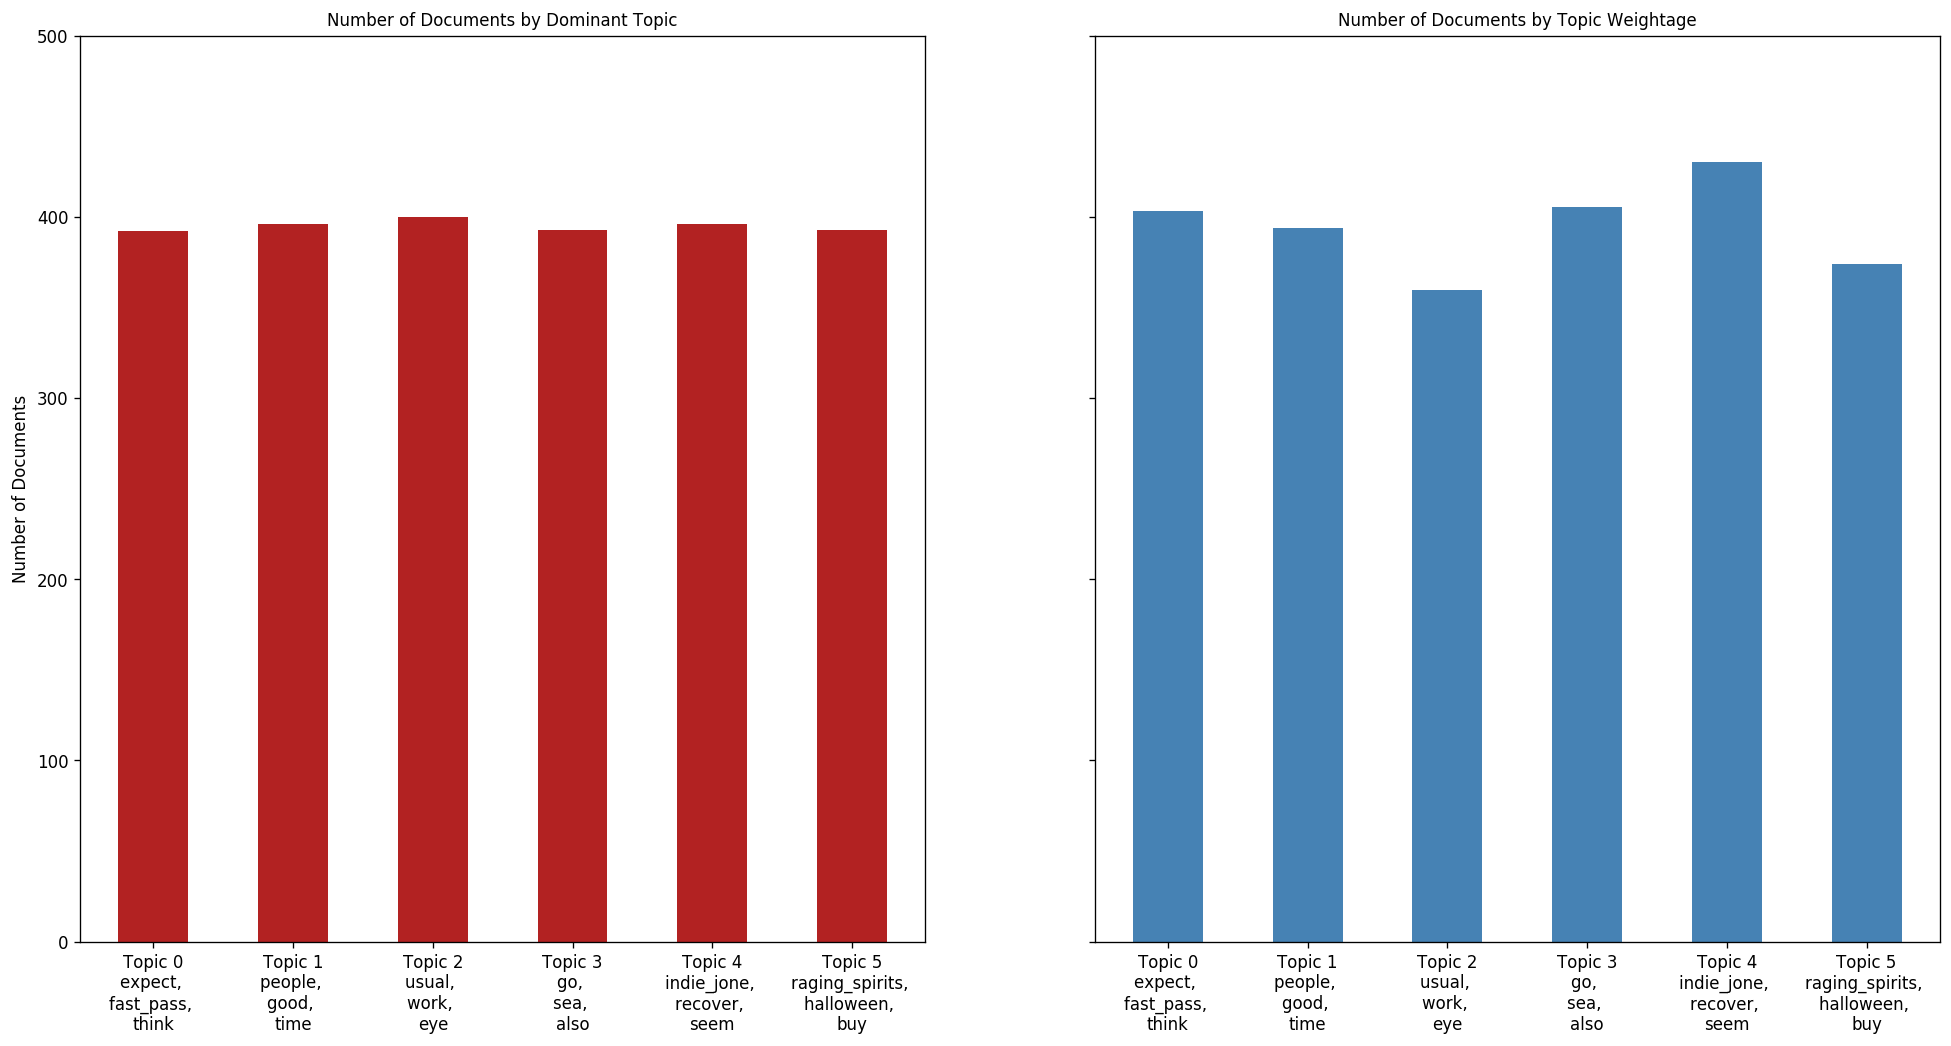

In [27]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 500)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [28]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state= 77, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2015 samples in 0.001s...
[t-SNE] Computed neighbors for 2015 samples in 0.051s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2015
[t-SNE] Computed conditional probabilities for sample 2000 / 2015
[t-SNE] Computed conditional probabilities for sample 2015 / 2015
[t-SNE] Mean sigma: 0.082025
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.172852
[t-SNE] KL divergence after 1000 iterations: 0.691346


In [29]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

In [30]:
num_topics = 6
topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(lda_model,topic_number=i, topn=10, output=True )
#     print tmp[:5]
    topic_summaries += [tmp[:5]]
    print

term                 frequency

Topic 0 |---------------------

expect               0.035
fast_pass            0.035
think                0.030
want                 0.026
say                  0.021
take                 0.016
show                 0.015
first                0.015
last                 0.015
wait                 0.015
Topic 1 |---------------------

people               0.044
good                 0.026
time                 0.025
ghost                0.023
person               0.023
try                  0.022
mean                 0.015
second               0.014
bad                  0.011
information          0.009
Topic 2 |---------------------

usual                0.054
work                 0.025
eye                  0.020
know                 0.015
gachapin             0.013
change               0.012
end                  0.012
minnie               0.011
serious              0.010
tag                  0.009
Topic 3 |---------------------

go                   0.045
sea

In [31]:
# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 6
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700,tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave")
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])

show(plot)

Loading BokehJS ...

In [32]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/Users/justin/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.148245 -0.228954       1        1  18.179760
3     -0.018952 -0.022387       2        1  17.979212
0      0.270221 -0.070446       3        1  17.905491
1      0.003895  0.058549       4        1  16.798752
5     -0.074360  0.167149       5        1  15.158747
2     -0.032559  0.096089       6        1  13.978042, topic_info=     Category        Freq            Term       Total  loglift  logprob
1273  Default  145.000000           usual  145.000000  30.0000  30.0000
107   Default  156.000000              go  156.000000  29.0000  29.0000
27    Default  142.000000          people  142.000000  28.0000  28.0000
4845  Default  131.000000  raging_spirits  131.000000  27.0000  27.0000
4515  Default  137.000000      indie_jone  137.000000  26.0000  26.0000
...       ...         ...             ...         ...      ...      ...
4647   Topic6   34.624680        gachapin   38.873962   1.8519  -4.3518
1420   Topic6   21.484236           often   23.934505   1.8597  -4.8291
145    Topic6   16.420506           power   21.343046   1.7055  -5.0979
2095   Topic6   14.861295             log   17.925356   1.7802  -5.1976
4415   Topic6   17.678902         expense   39.123257   1.1733  -5.0240

[235 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
242       5  0.989154      able
2092      3  0.977113  addition
2359      1  0.971942    almost
53        3  0.947658   already
87        2  0.993655      also
...     ...       ...       ...
155       1  0.981548    wonder
171       6  0.988718      work
683       5  0.953352   worried
600       1  0.954874       www
532       1  0.953128       スフフ

[239 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 1, 2, 6, 3])